In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv1D, UpSampling1D, Dropout, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler, ReduceLROnPlateau

import numpy as np

import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

from time import time
import os

from scipy.signal import spectrogram, istft

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


Using TensorFlow backend.


## Load data and preprocess

In [3]:
waveform_filename = 'hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms_PREPROCESSED.mseed'

if os.path.exists(waveform_filename):
    print('{} exists, loading'.format(waveform_filename))
    stream = obspy.read(waveform_filename)
    
else:
    print("{} doesn't exist, processing file".format(waveform_filename))
    stream = obspy.read('hawaii_Apr-Aug-2018_mag31.5_POHA_waveforms.mseed')

    client = Client('IRIS')

    starttime = UTCDateTime('2018-04-01')
    endtime = UTCDateTime('2018-8-31')
    POHA = client.get_stations(network="IU", station="POHA", 
                               starttime=starttime, endtime=endtime,
                              level='response')

    print("Removing seismometer response...")
    stream.remove_response(POHA)
    print("Filtering waveforms...")
    stream.filter('bandpass', freqmin=3, freqmax=8, corners=2, zerophase=True)
    print("Normalizing waveforms...")
    stream.normalize()
    print("Done")

    stream.write('hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms_PREPROCESSED.mseed')
    
     

hawaii_Apr-Aug-2018_mag1.5_POHA_waveforms_PREPROCESSED.mseed exists, loading


## Create Spectrograms

In [4]:
df = 20
trace_length = 40

spectrograms = []

for tr in stream:
    if len(tr.data) == trace_length*df:
        _, _, Sxx = spectrogram(tr.data, nperseg=int(df*2), scaling='spectrum')
        spectrograms.append(Sxx.T)
f = plt.figure(figsize=(2,2))    
plt.pcolormesh(spectrograms[10].T)
print(len(spectrograms))

<IPython.core.display.Javascript object>

41474


In [5]:
f = plt.figure(figsize=(2,2))
plt.pcolormesh(spectrograms[40000])

<IPython.core.display.Javascript object>

In [6]:
np.array(spectrograms).shape


(41474, 22, 21)

In [7]:
X = np.array(spectrograms)

X_train = X[:40000]
X_val = X[40000:]

# Create a 1D causal convolutional autoencoder for seismic spectrogram feature extraction

based on https://blog.keras.io/building-autoencoders-in-keras.html, https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb

In [8]:
# Maybe I should class this

def build_model(latent_dims, input_shape, n_filters=32, dilation_rate=2, n_layers=4):
    
    # ENCODER
    encoder_input = Input(shape=input_shape)  # adapt this if using `channels_first` image data format
    x = encoder_input
    
    for i in [dilation_rate**i for i in range(n_layers)]:
        x = Conv1D(n_filters, 2, dilation_rate=i, activation='relu', padding='causal')(x)

    encode = Flatten()(x)
    encode = Dense(latent_dims)(encode)
    encode = Reshape((1,latent_dims))(encode)

    # DECODER
    #decoder_input = Input(shape=(1,latent_dims))
    decode = Dense(input_shape[0], activation='relu')(encode)
    decode = Reshape((input_shape[0],1))(decode)
    #x = decoder
    
    for i in [dilation_rate**i for i in range(n_layers)][::-1][:-1]:
        #last step should be a dilatation of 1, skip this to put a sigmoid activation on last layer
        decode = Conv1D(n_filters, 2, dilation_rate=i,activation='relu', padding='causal')(decode)
        #x = UpSampling1D(2)(x)      

    decode = Conv1D(n_filters, 2, dilation_rate=1, activation='sigmoid', padding='causal')(decode)
    decode = Dense(input_shape[1])(decode)

    encoder = Model(encoder_input, encode)
    #decoder = Model(decoder_input, decode)
    autoencoder = Model(encoder_input, decode)
    
    #decoder = Model(latent, decoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    #encoder.compile()
    
    return autoencoder, encoder #, decoder

## Set latent_dims equal to the number of clusters to directly train the clusters
At some point, either softmax the latent vector and/or train to directly create a sparse vector containing a 1 in the position of the cluster and 0 otherwise.

Can also somehow add a cluster loss function to the training to create better clusters.

Then train multiple nets for different cluster numbers and use something like elbow or silhouette method to select best

In [10]:
n_filters = 64
latent_dims = 4
n_layers = 4
model_time = time()

input_shape = (spectrograms[0].shape[0], spectrograms[0].shape[1])
autoencoder, encoder = build_model(latent_dims, (input_shape))

autoencoder.summary()

'''# create decoder model
inp = Input(shape=(10,))
m=inp
for layer in autoencoder.layers[8:]:
    m = layer(m)
    
decoder = Model(inp,m)

decoder.compile(optimizer='adam', loss='mse')'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 22, 21)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 22, 32)            1376      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 22, 32)            2080      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 22, 32)            2080      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 22, 32)            2080      
_________________________________________________________________
flatten_2 (Flatten)          (None, 704)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 2820      
__________

"# create decoder model\ninp = Input(shape=(10,))\nm=inp\nfor layer in autoencoder.layers[8:]:\n    m = layer(m)\n    \ndecoder = Model(inp,m)\n\ndecoder.compile(optimizer='adam', loss='mse')"

In [ ]:
checkpoint = ModelCheckpoint('convolutional_spectrogram-latent_vectors=n_clusters/weights/weights_{}layers_{}filters_{}latent_{}.hdf5'.format(n_layers, n_filters, latent_dims,model_time), 
                                monitor='loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='convolutional_spectrogram-latent_vectors=n_clusters/logs/log_{}layers_{}filters_{}latent_{}'.format(n_layers,n_filters, latent_dims, model_time))
#lrscheduler = LearningRateSchedular
reduceLR = ReduceLROnPlateau(patience=25, factor=0.3, min_delta=0.001)
callbacks = [checkpoint, tensorboard]#, reduceLR]

autoencoder.fit(X_train, X_train, 
                validation_data=(X_val,X_val),
                batch_size=512, 
                epochs=500,  
                shuffle=True,
                callbacks=callbacks)

In [24]:
autoencoder.load_weights('convolutional_spectrogram-latent_vectors=n_clusters/weights/weights_{}layers_{}filters_{}latent_{}.hdf5'.format(n_layers, n_filters, latent_dims,model_time))

<IPython.core.display.Javascript object>


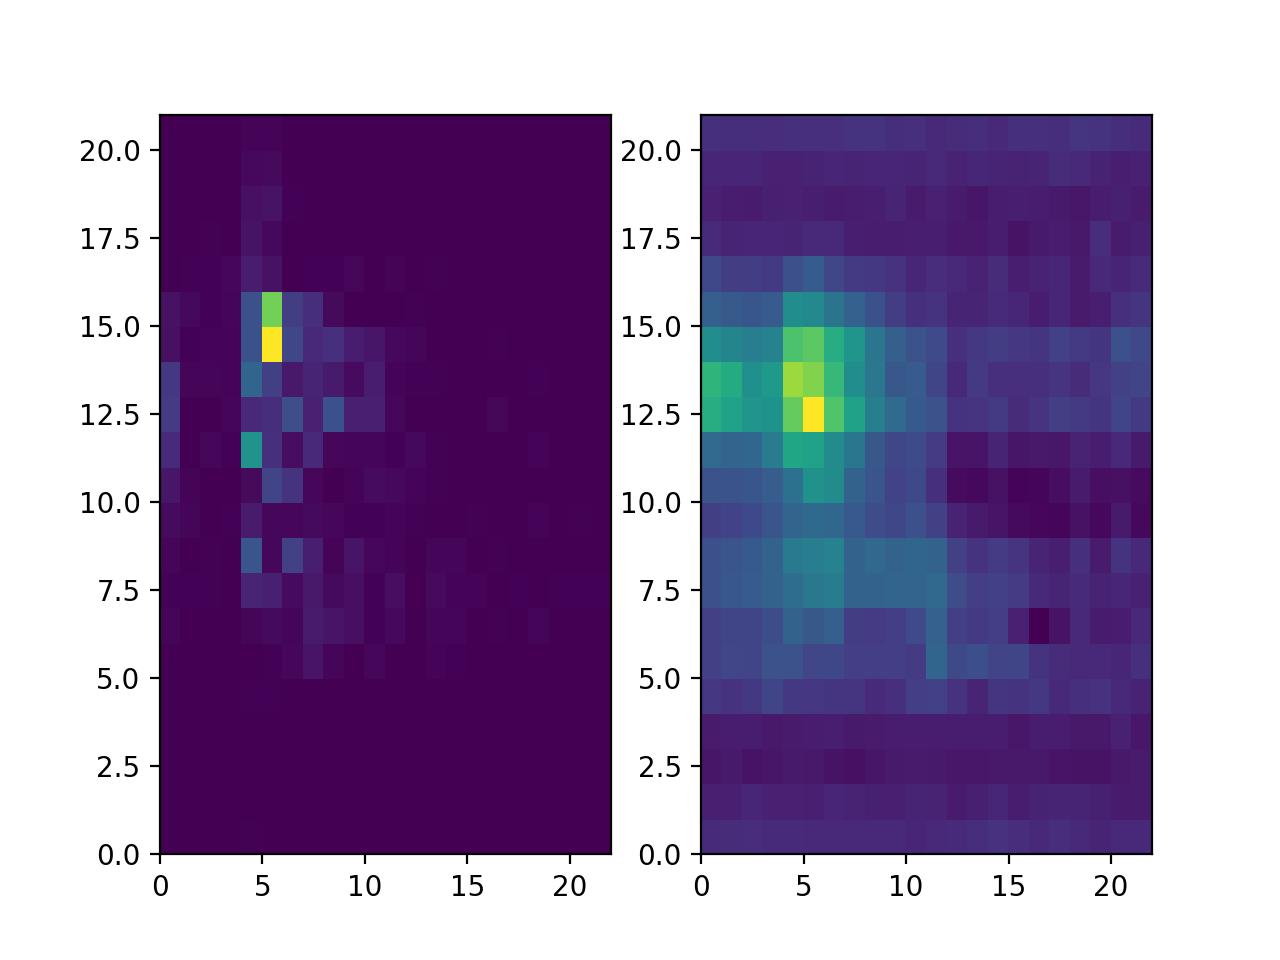

In [29]:
#fig = plt.figure(figsize=(20,5))
f, (ax1, ax2) = plt.subplots(1,2)
j = 2
ax1.pcolormesh(X[j].T)
predict = autoencoder.predict(X[j].reshape(1,X[j].shape[0],X[j].shape[1]))
ax2.pcolormesh(predict.T.reshape(X[j].shape[1],X[j].shape[0]))

<IPython.core.display.Javascript object>


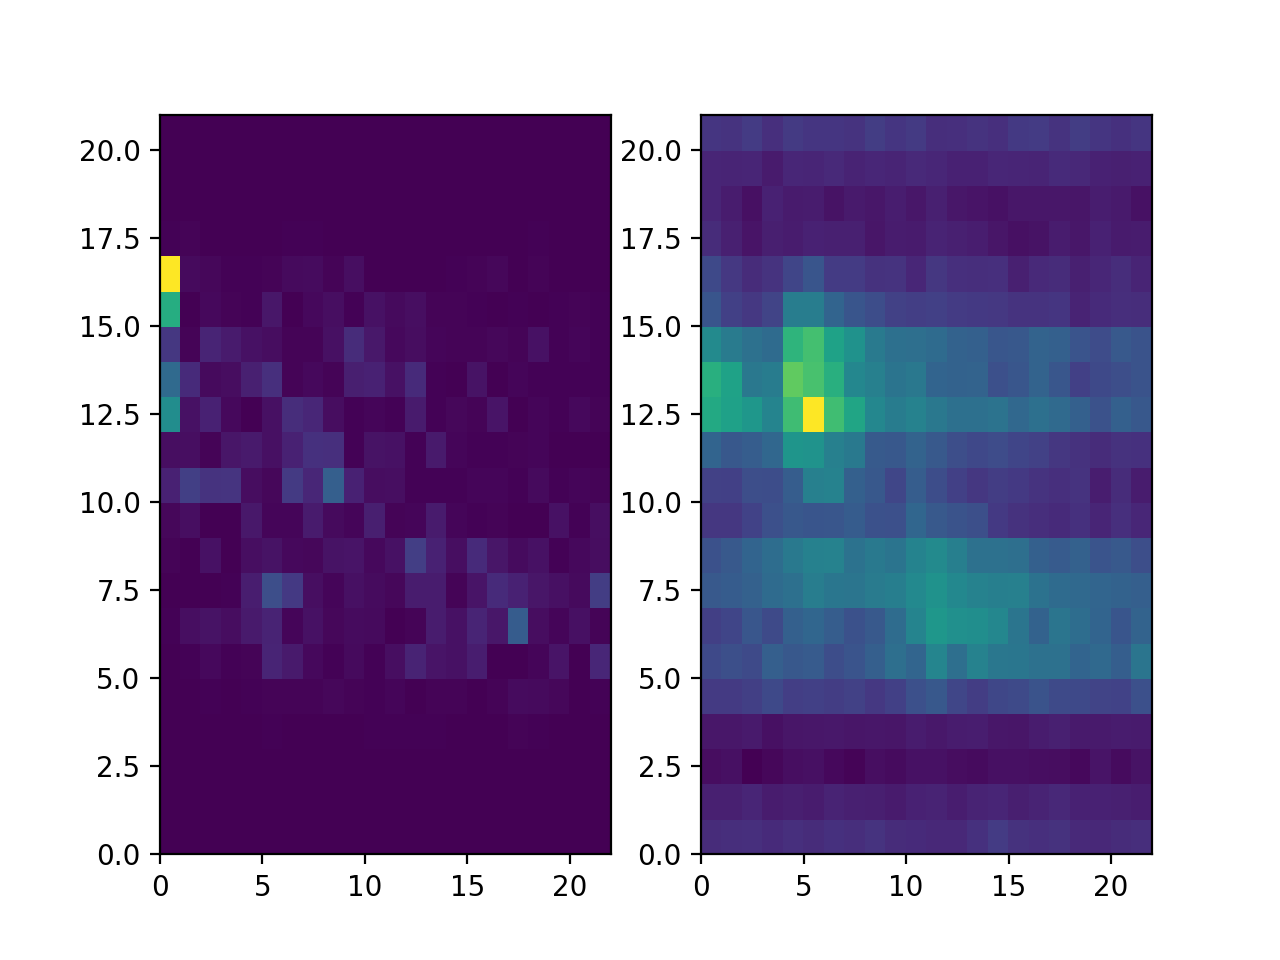

In [30]:
f, (ax1, ax2) = plt.subplots(1,2)
j = 41000
ax1.pcolormesh(X[j].T)
predict = autoencoder.predict(X[j].reshape(1,X[j].shape[0],X[j].shape[1]))
ax2.pcolormesh(predict.T.reshape(X[j].shape[1],X[j].shape[0]))

In [31]:
encoder.compile(optimizer='adam', loss='mse')

In [41]:
latent_vectors = encoder.predict(X)
latent_vectors = latent_vectors.reshape(latent_vectors.shape[0],latent_vectors.shape[2])

## K-means clustering

In [42]:
kmeans = KMeans(latent_dims)

clusters = kmeans.fit_predict(latent_vectors)

### 2D PCA 

<IPython.core.display.Javascript object>


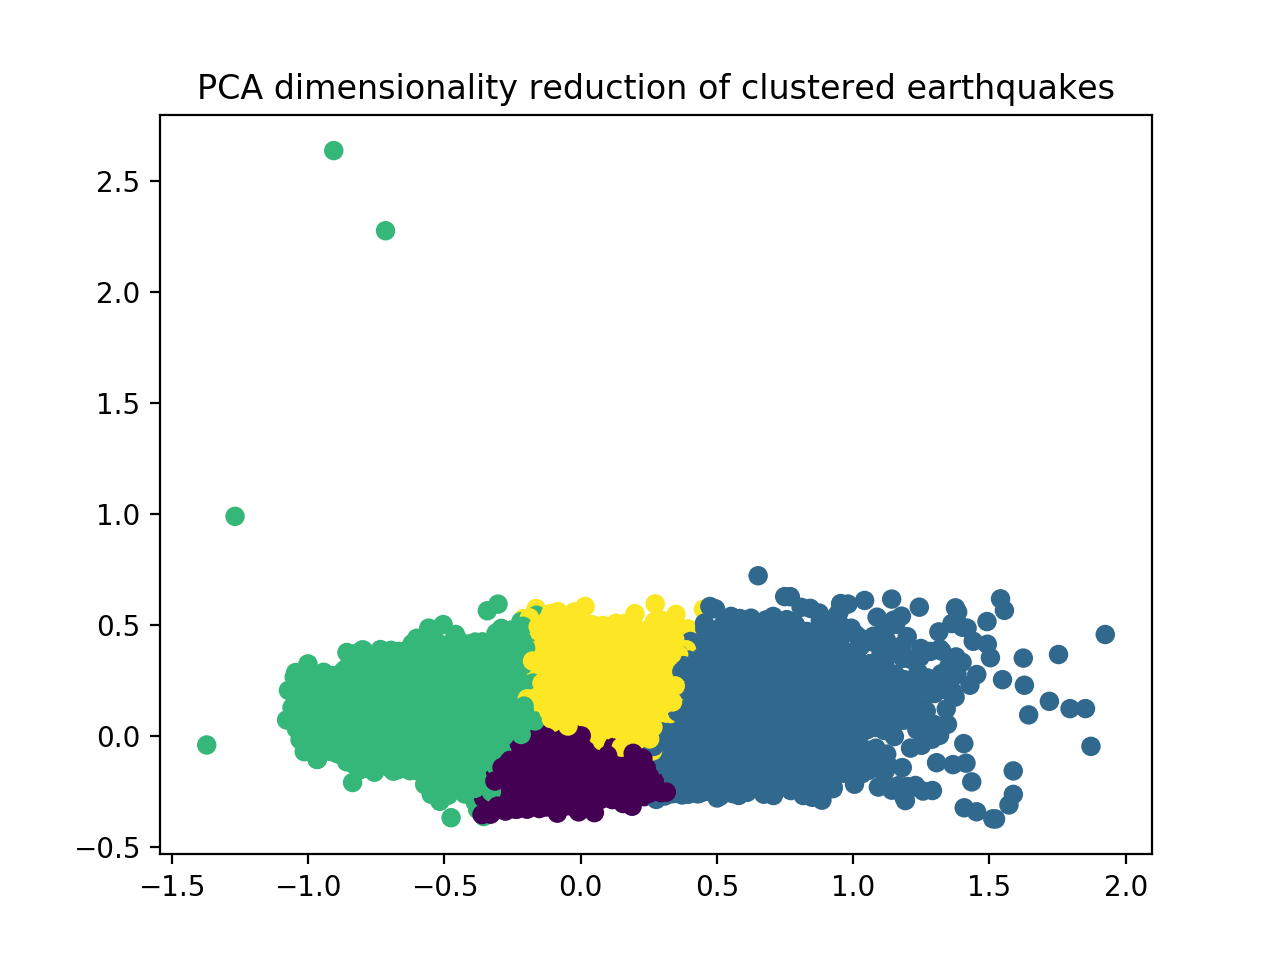

Text(0.5, 1.0, 'PCA dimensionality reduction of clustered earthquakes')

In [43]:
pca = PCA(n_components=2).fit_transform(latent_vectors)
f = plt.figure()
plt.scatter(pca[:,0], pca[:,1], c=clusters)
plt.title('PCA dimensionality reduction of clustered earthquakes')

### 3D PCA

<IPython.core.display.Javascript object>


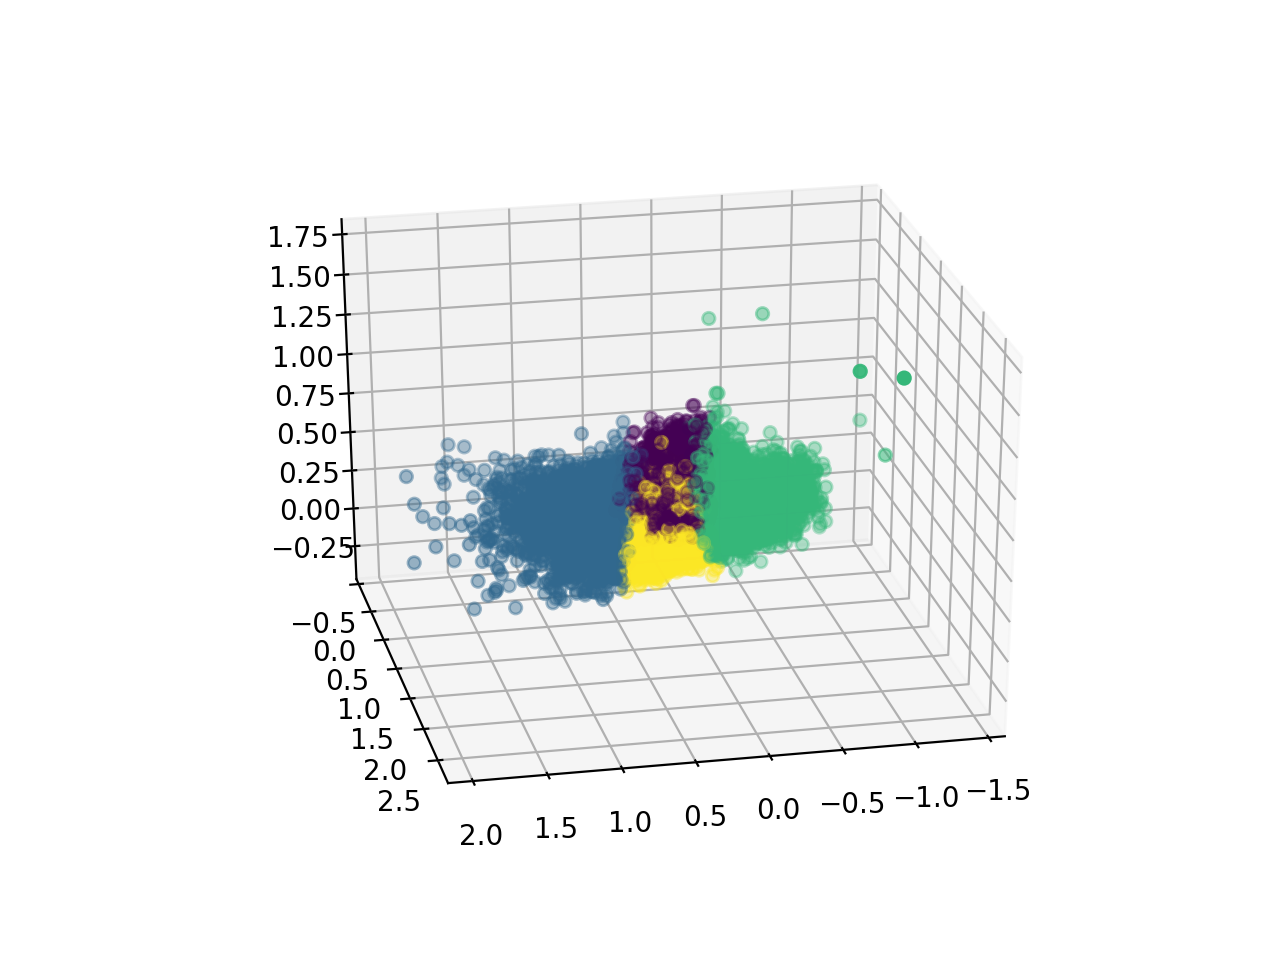

In [44]:
dpca = PCA(n_components=3).fit_transform(latent_vectors)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dpca[:,0], dpca[:,1], dpca[:,2], c=clusters)


### T-sne

In [45]:
ts = TSNE(perplexity=40).fit_transform(latent_vectors[:5000])



<IPython.core.display.Javascript object>


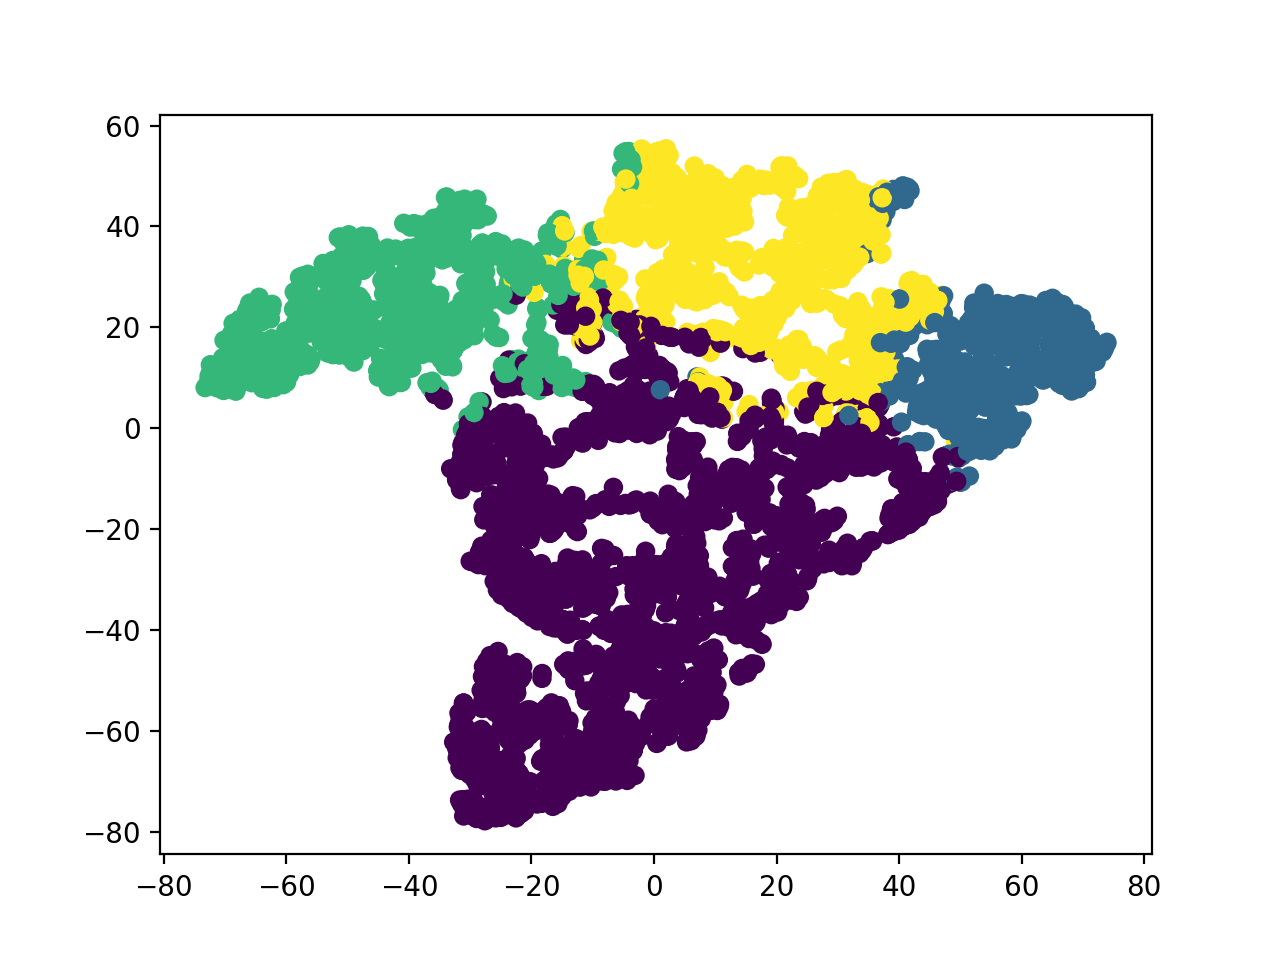

In [46]:
f = plt.figure()
plt.scatter(ts[:,0],ts[:,1], c=clusters[:5000])

## Plot some spectrograms for each cluster

If I can get the decoder part to work, would be helpful to plot spectrograms for each cluster centroid
Also need to do statistics of each cluster, e.g., magnitude distributions, spatial distributions


In [47]:
# group spectrograms by cluster, also add event info
cat = obspy.core.event.read_events('hawaii_Apr-Aug-2018_mag1.5_POHA_catalog.xml')

predicted = autoencoder.predict(X)

import pandas as pd

clustered = pd.DataFrame({'cluster':clusters, 
                          'spectrogram':[x for x in X[:]], 
                          'predicted':[x for x in predicted[:]],
                         'event':[x for x in cat]})


### Cluster 0

<IPython.core.display.Javascript object>


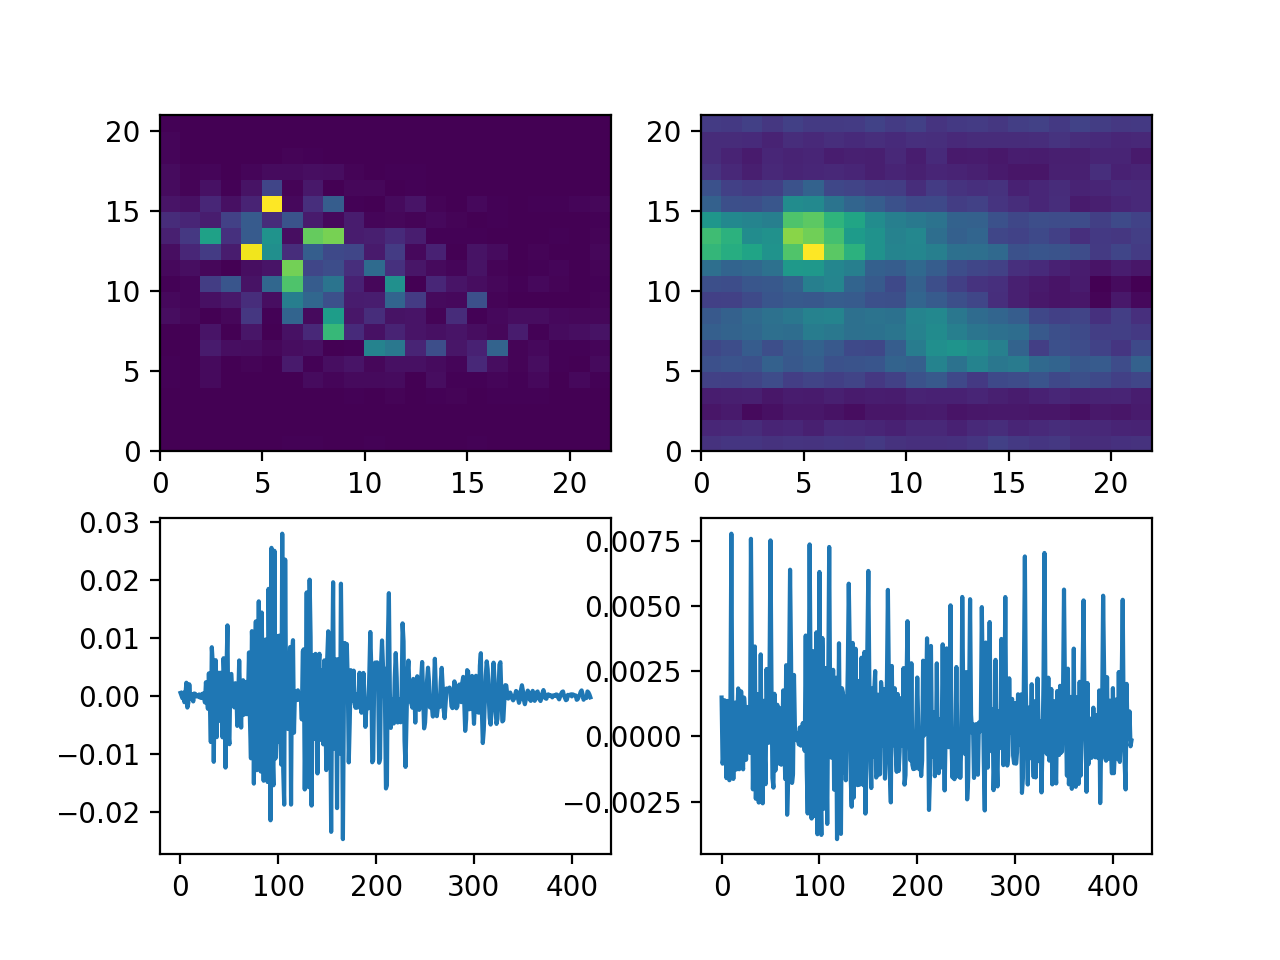

In [82]:
j = 10

spect = clustered[clustered.cluster==0].iloc[j].spectrogram
pred = clustered[clustered.cluster==0].iloc[j].predicted

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.pcolormesh(spect.T)
ax2.pcolormesh(pred.T)
ax3.plot(istft(spect.T)[1])
ax4.plot(istft(pred.T)[1])



### Cluster 1

<IPython.core.display.Javascript object>


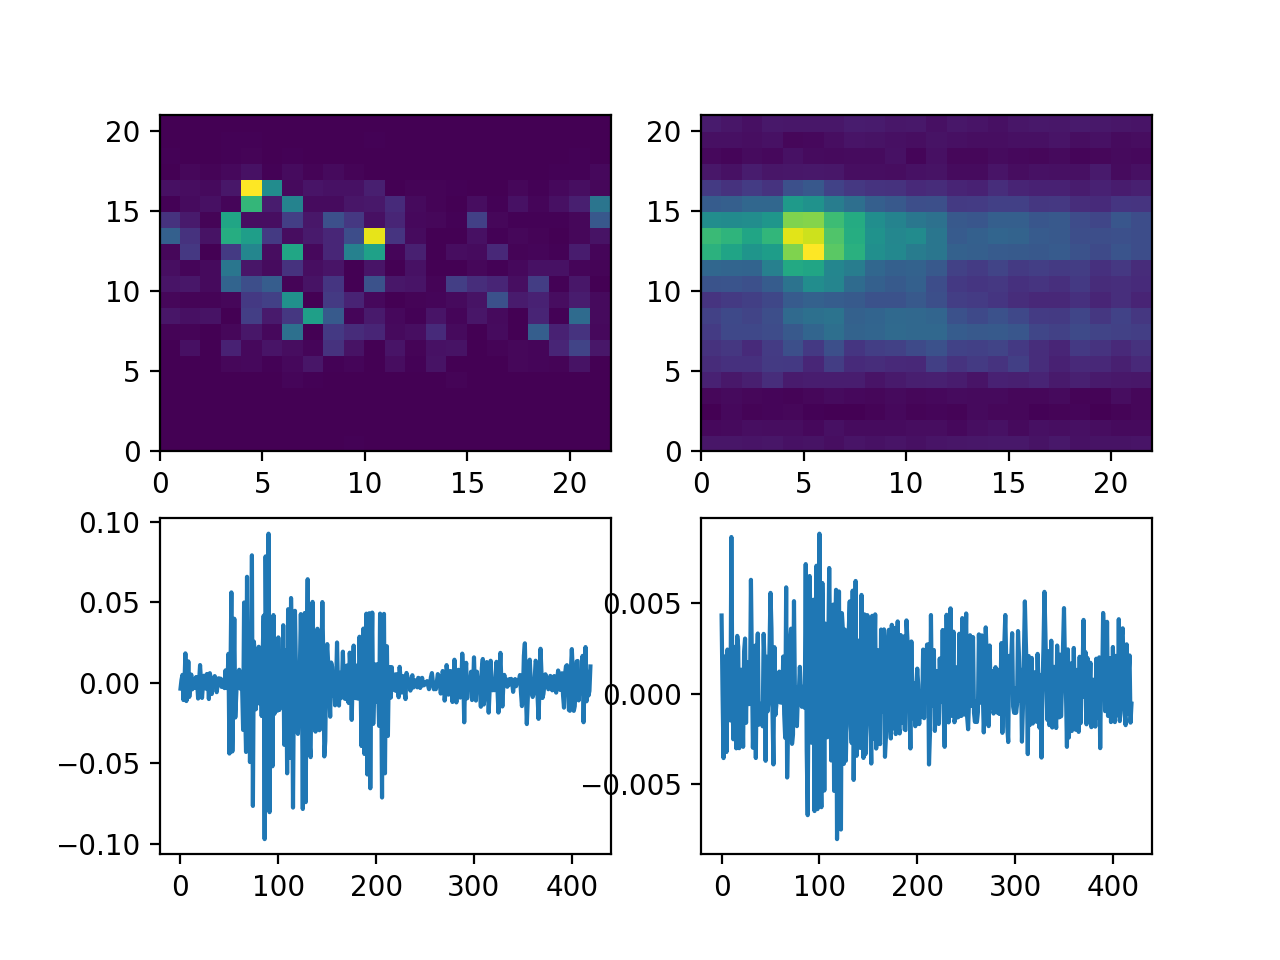

In [83]:
j = 20

spect = clustered[clustered.cluster==1].iloc[j].spectrogram
pred = clustered[clustered.cluster==1].iloc[j].predicted

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.pcolormesh(spect.T)
ax2.pcolormesh(pred.T)
ax3.plot(istft(spect.T)[1])
ax4.plot(istft(pred.T)[1])


### Cluster 2

<IPython.core.display.Javascript object>


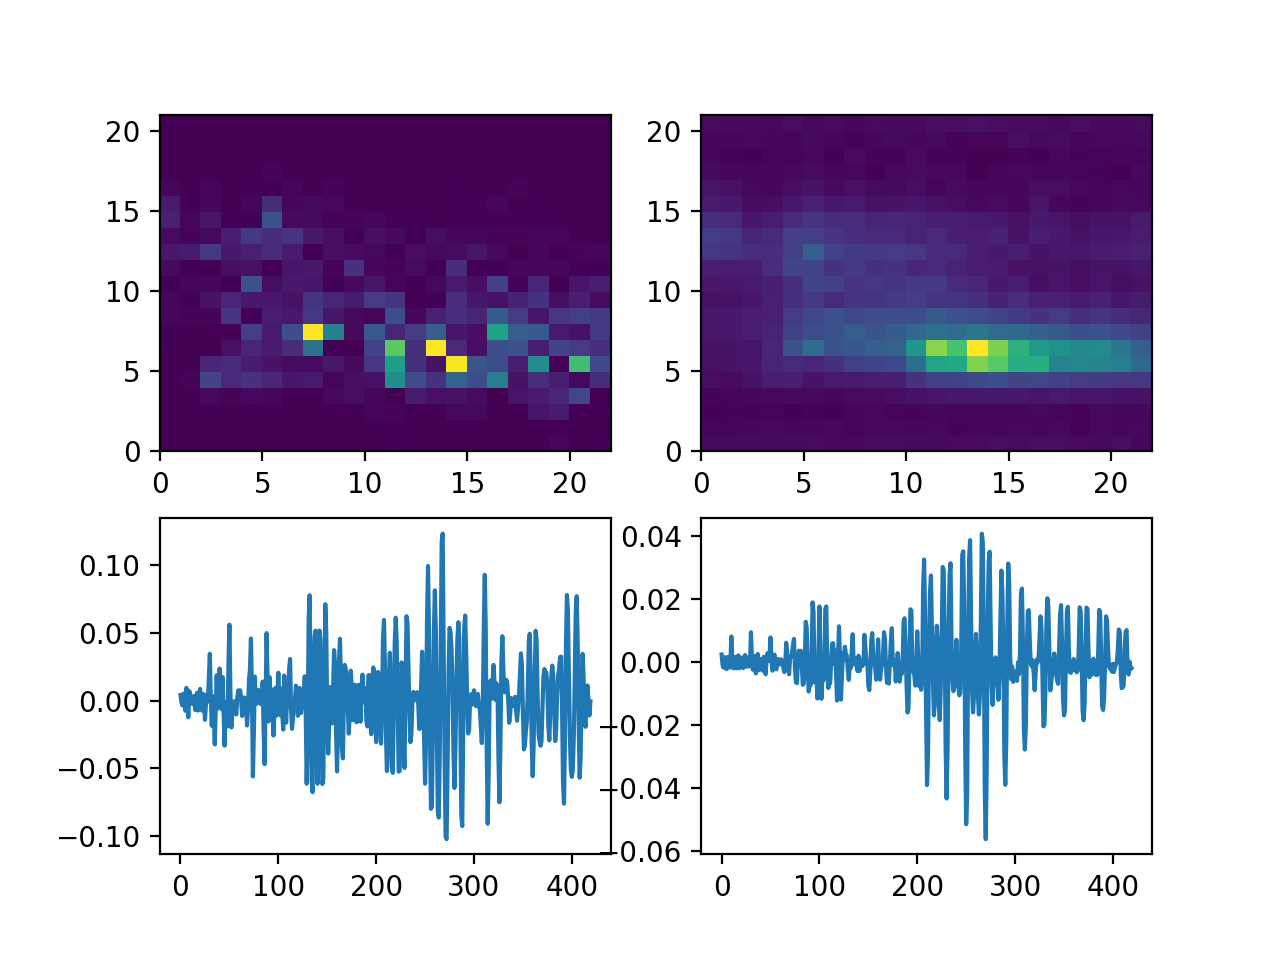

In [84]:
j = 100

spect = clustered[clustered.cluster==2].iloc[j].spectrogram
pred = clustered[clustered.cluster==2].iloc[j].predicted

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
j = 20000
ax1.pcolormesh(spect.T)
ax2.pcolormesh(pred.T)
ax3.plot(istft(spect.T)[1])
ax4.plot(istft(pred.T)[1])


### Cluster 3

<IPython.core.display.Javascript object>


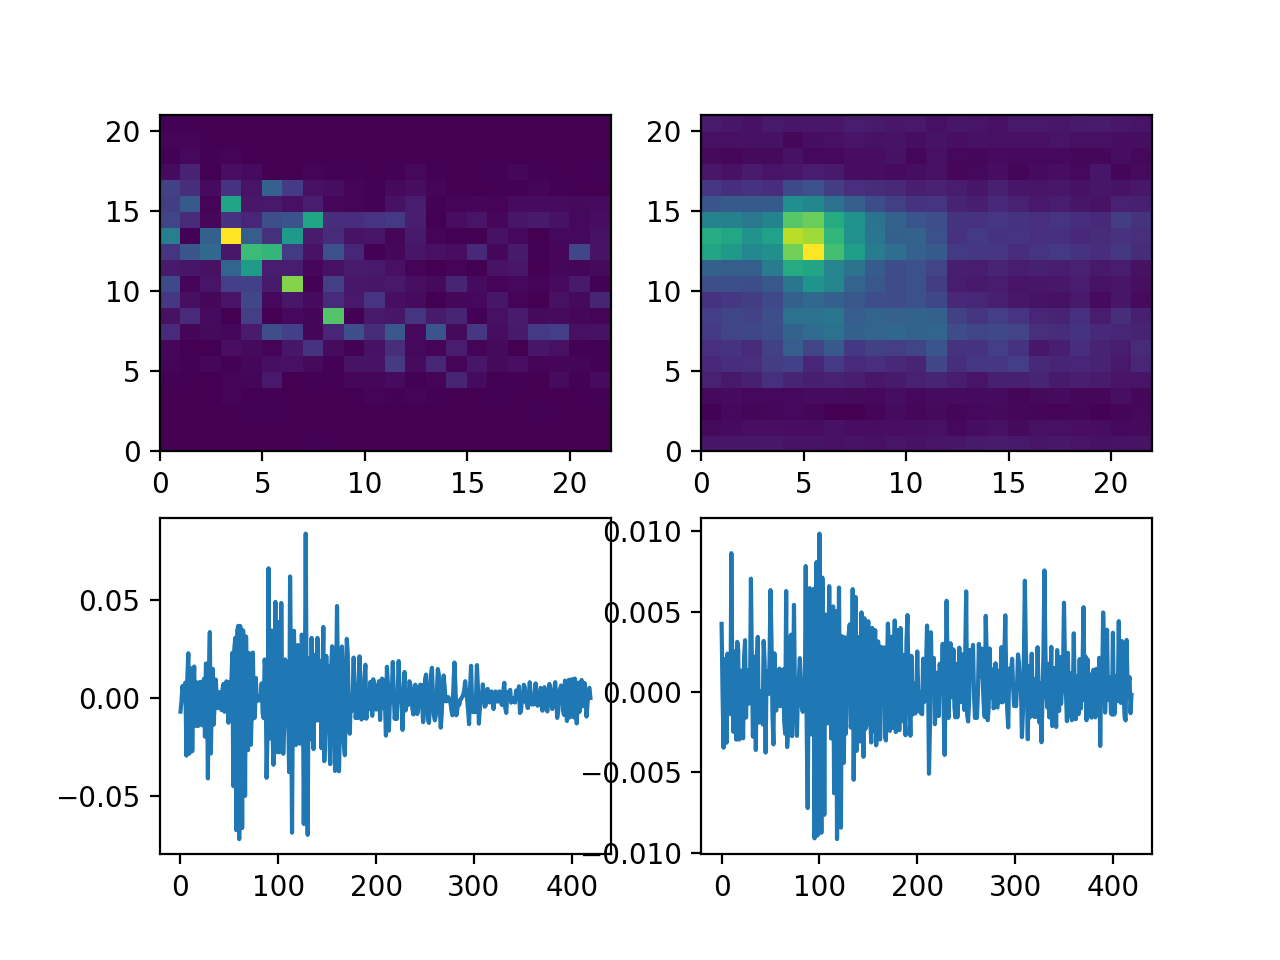

In [85]:
j = 2000

spect = clustered[clustered.cluster==3].iloc[j].spectrogram
pred = clustered[clustered.cluster==3].iloc[j].predicted

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
j = 20000
ax1.pcolormesh(spect.T)
ax2.pcolormesh(pred.T)
ax3.plot(istft(spect.T)[1])
ax4.plot(istft(pred.T)[1])


## Look at the reconstructed spectrograms of the cluster centers

In [64]:
inp = Input(shape=(latent_dims,))
m=inp
for layer in autoencoder.layers[8:]:
    m = layer(m)
    
decoder = Model(inp,m)

decoder.compile(optimizer='adam', loss='mse')

decoder.summary()

centroid_spectrograms = decoder.predict(kmeans.cluster_centers_)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              multiple                  110       
_________________________________________________________________
reshape_4 (Reshape)          (None, 22, 1)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 22, 32)            96        
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 22, 32)            2080      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 22, 32)            2080      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 22, 32)            2080      
__________

<IPython.core.display.Javascript object>


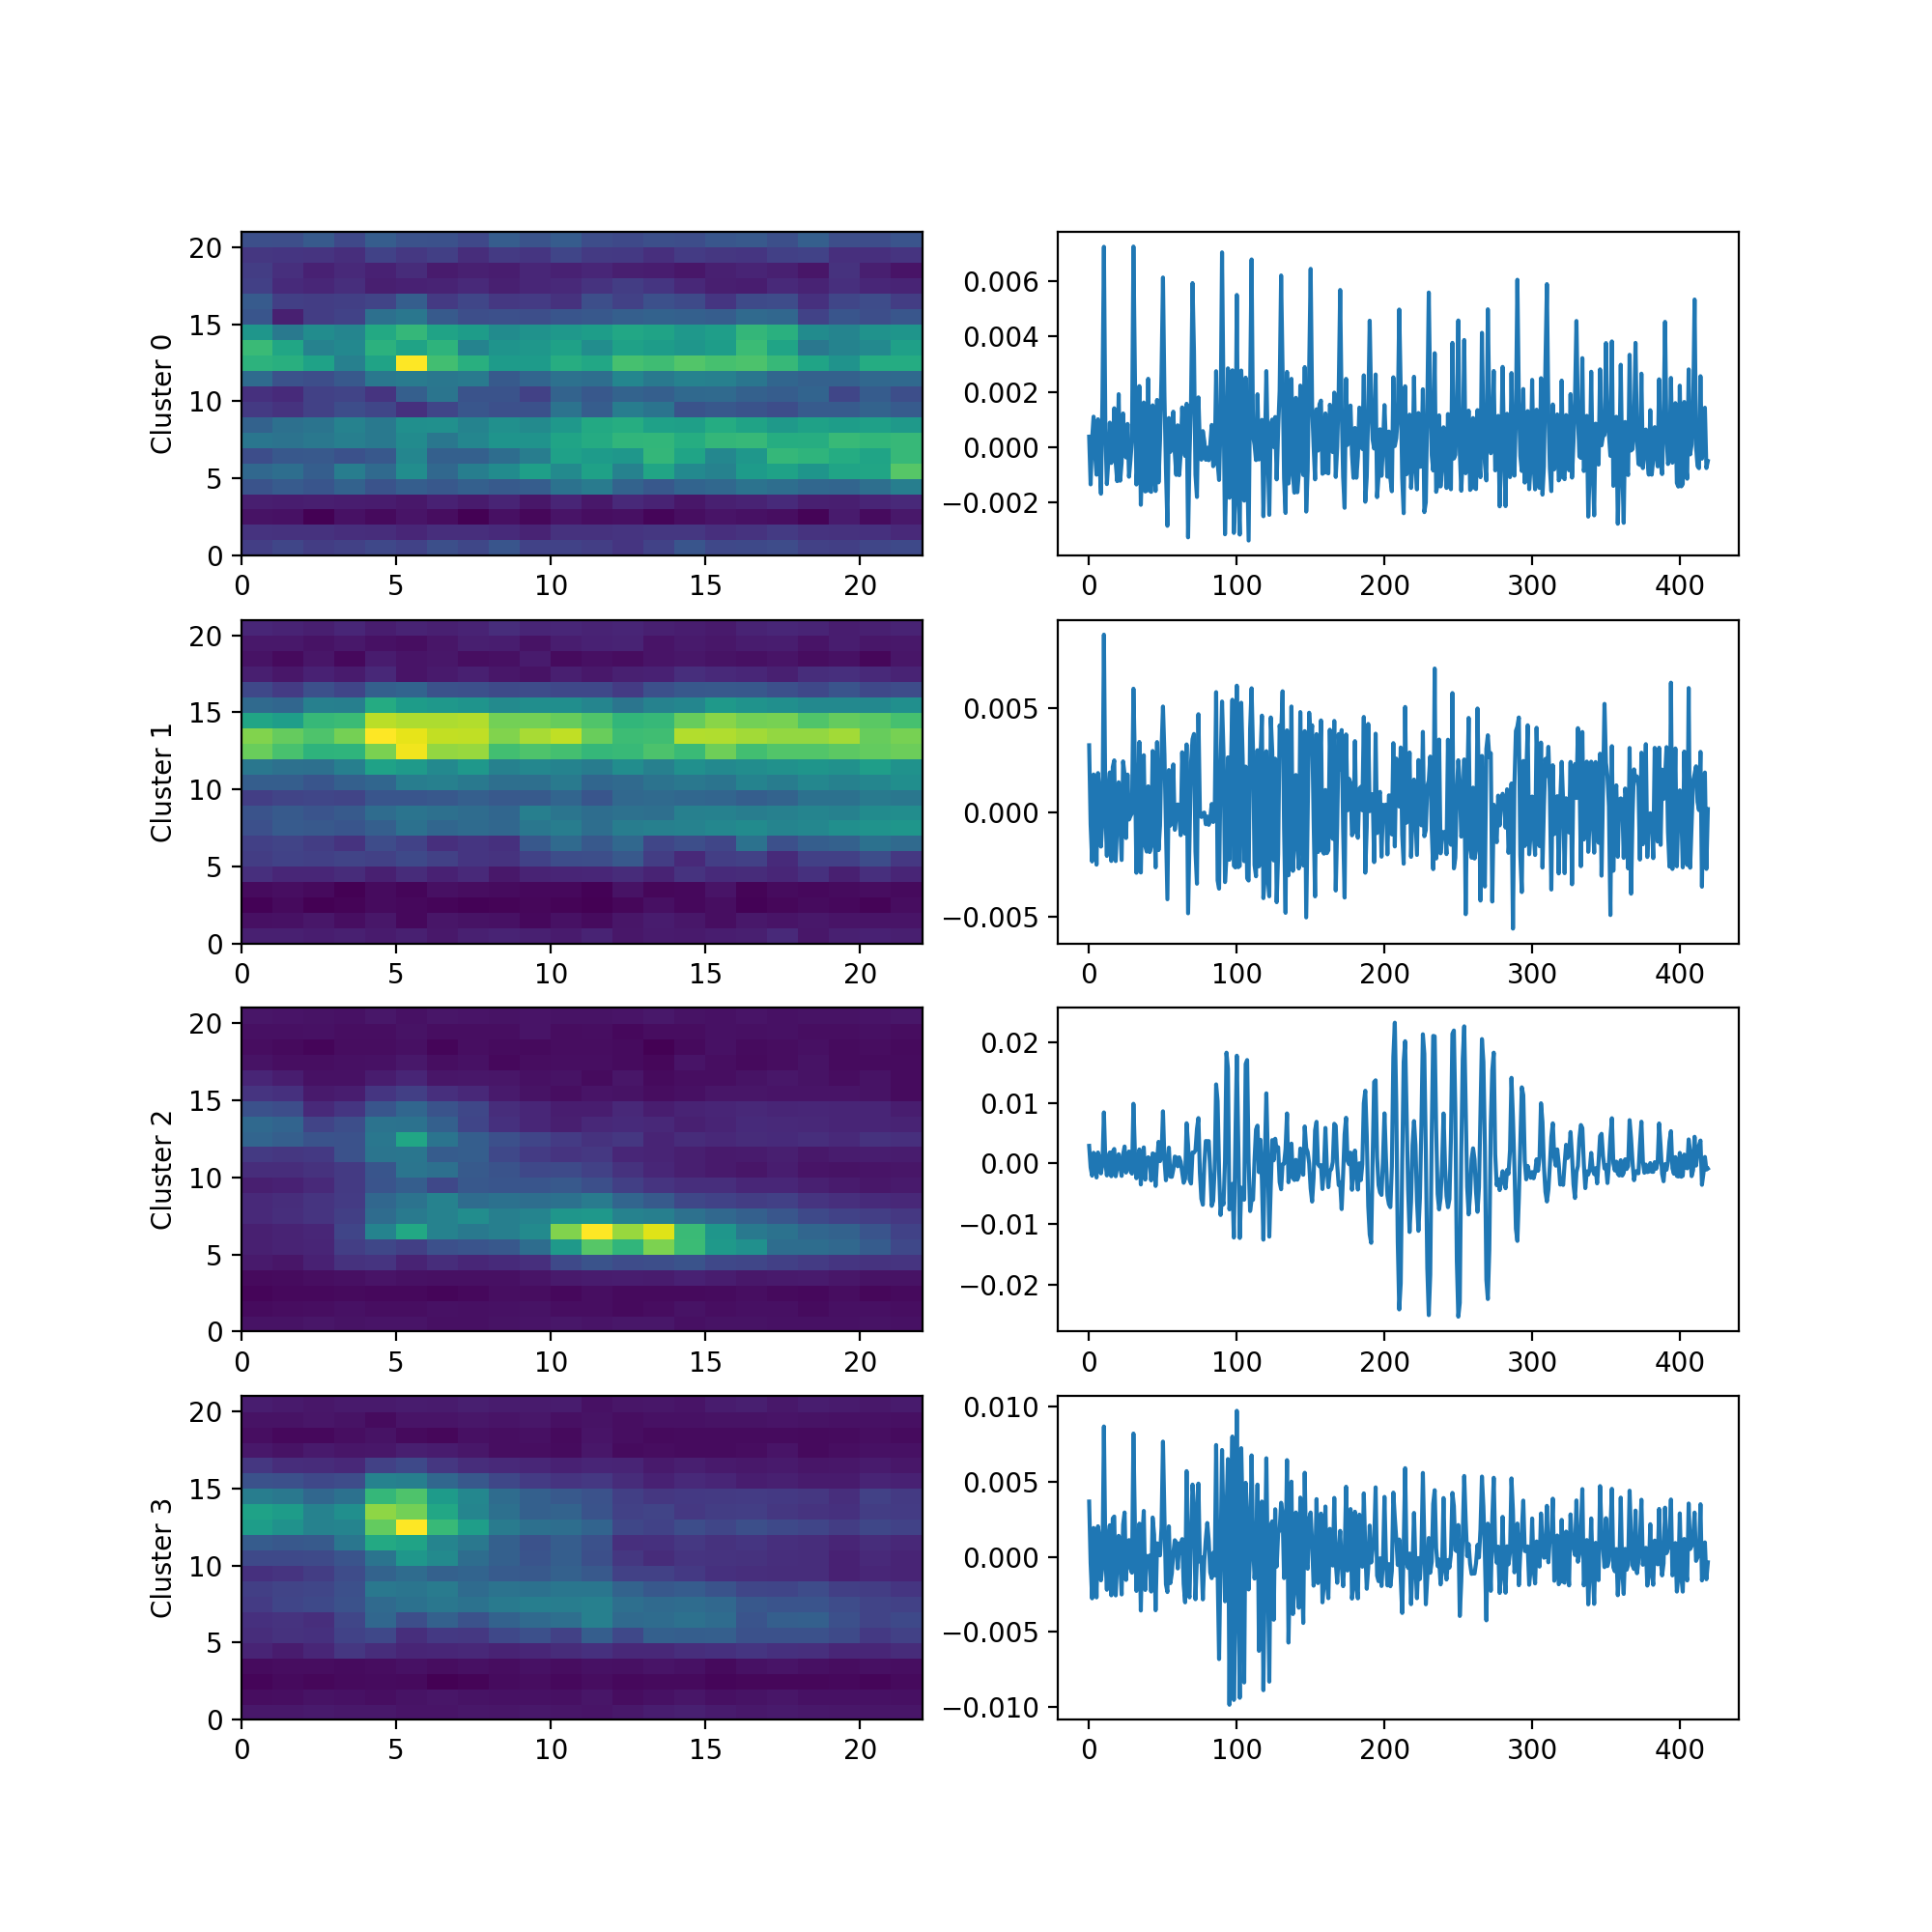

In [91]:
#spect = centroid_spectrograms[0]


f, axes = plt.subplots(4,2, figsize=(10,10))

#f.set_title('Spectrograms and Waveforms for cluster centroid vectors')

for i, spect in enumerate(centroid_spectrograms):
    axes[i,0].pcolormesh(spect.T)
    axes[i,0].set_ylabel('Cluster {}'.format(i))
    axes[i,1].plot(istft(spect.T)[1])
    #axes[i,1].set_title('Cluster {} canonical centroid waveform'.format(i))


<IPython.core.display.Javascript object>


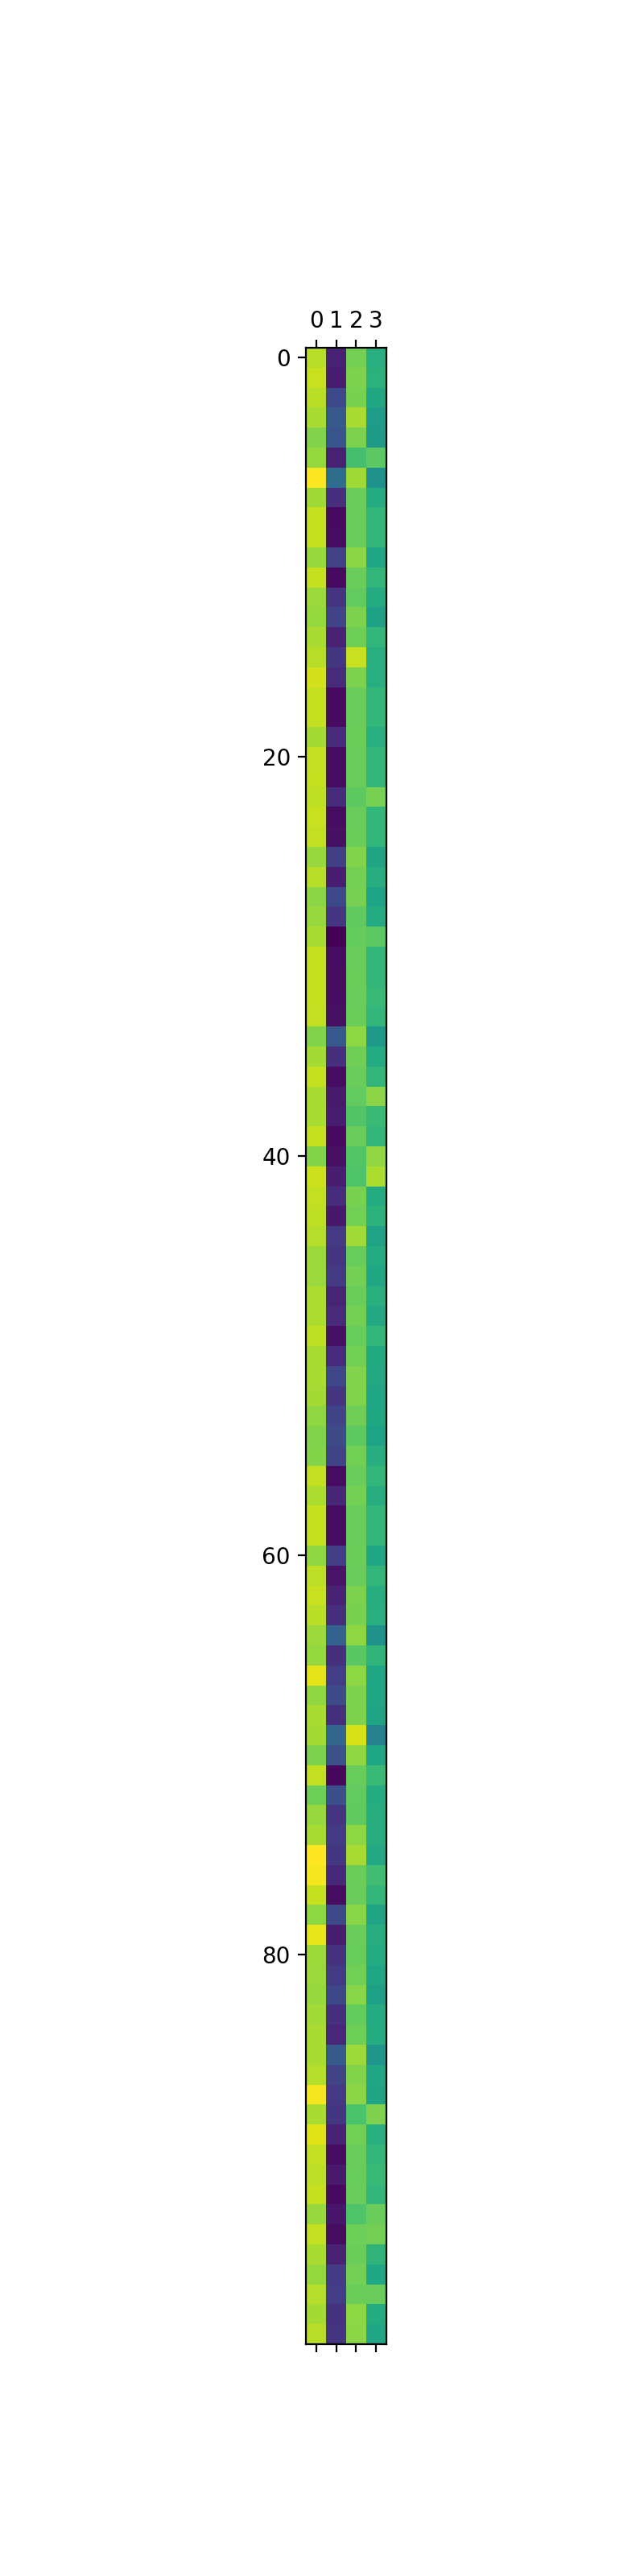

In [56]:
plt.matshow(latent_vectors[100:200])

<IPython.core.display.Javascript object>


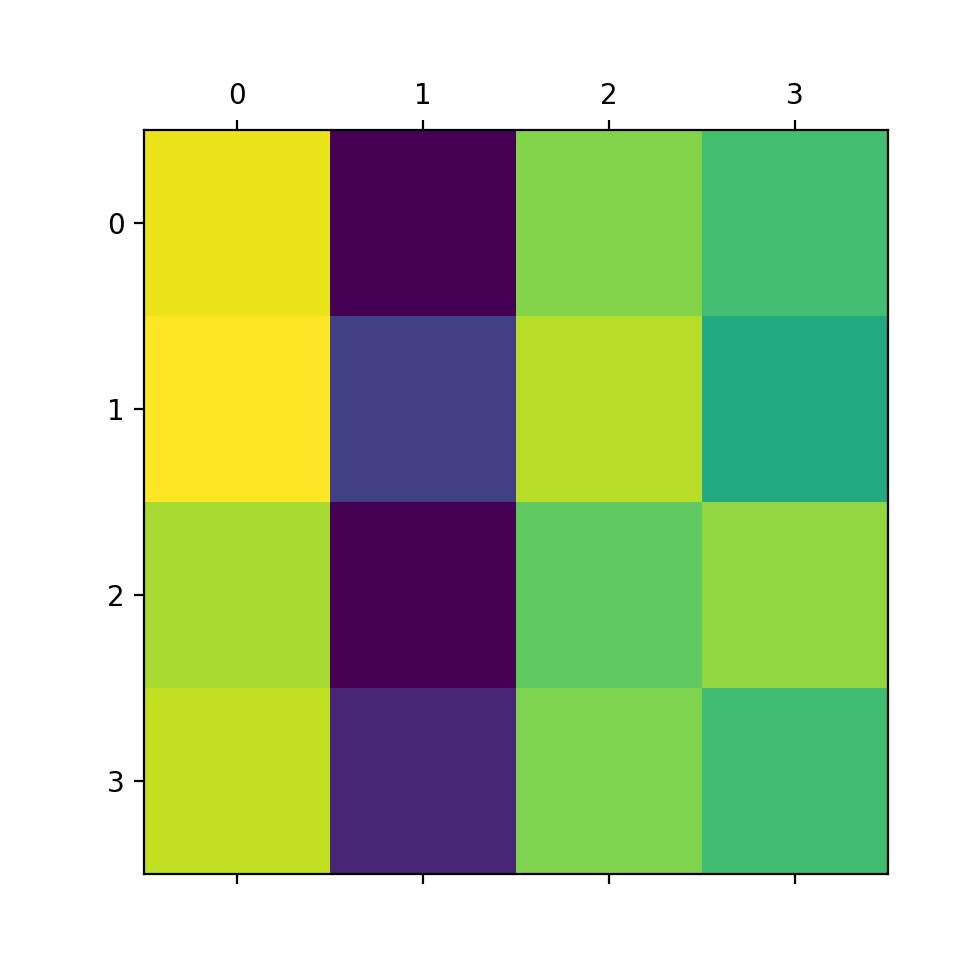

In [58]:
plt.matshow(kmeans.cluster_centers_)

### From the above plots, the latent vectors are very similar - is the latent space projection not rich enough?

In [ ]:
axes[1]

## Silhouette coefficients

In [80]:
from sklearn.metrics import silhouette_score

In [81]:
silhouette_score(latent_vectors, clusters)

0.38764066

In [ ]:
kmeans.